# Peer-graded Assignment: Week 4: BBC News Classification Kaggle Mini-Project
JF Schultz  
Oct 2023  
CU MSDS - DTSA 5510

# Introduction

This project examines the [Kaggle BBC News Classfication](https://www.kaggle.com/c/learn-ai-bbc) Challenge, specifically with a focus on the performance on non-negative matrix factorization in prediction.  

A copy of this html report, it's jupyter notebook, and bare code can be found on [my GitHub repository](https://github.com/miniwheat/kaggle-BBC-News).  

The entirety of the report is summarized in the Overview Section immediately below.  

I welcome any commentary or discussion, please feel free to reach out to me on Slack.

# Overview and Summary

The kaggle challenge is a **classification problem**.  A public dataset of BBC news articles is provided, each labeled as belonging to one of 5 categories: business, entertainment, politics, sport or tech.  The dataset of articles is divided into a training set of 1,490 articles with known category classification and 735 as a test set with unknown classification.  The desired task is to classify the test set of articles with accuracy as a scoring metric.  

To begin, **Exploratory Data Analysis** was performed and expressed in terms of visualizations.  The distribution of categories among the classified articles was not prohibitively unbalanced.  Before examining word counts, a helper function was used to clean and pre-process text.  This served to remove any numbers, punctuation, and lemmatize words to their stem, e.g. walk, walking, walks, walked lemmatized to walk. Word counts were then examined.  The average word count per article within each classified category was very similar for business, entertainment, and sport, and greater for articles about politics and tech, with the tech category having the noticeably greatest variation in word count per article.  The overall distribution of number of word occurrences was examined.  This showed that of the 24,456 words identified, only 5 occurred more than 1,000 times, and the overwhelming majority, 19,333 occurred less than ten times.  The distribution of words within the range from 100 - 1,000 showed most occurred at the lower frequencies.  The most common words overall were also identified and their relative counts visualized.  

**Modeling and class prediction** was performed with non-negative matrix factorization (NMF).  The entire corpus of documents was used by combining the training and test sets.  The words of each article were tokenized by word count and weighted by tf-idf (term frequency-inverse document frequency) providing a measure of each term's frequency within a document compared to its frequency across all documents.  In essence the tfidf weighting helps identify words unique to specific articles, that is terms which are very frequent within an article and relatively uncommon across all articles are weighted more heavily.  NMF was used as an unsupervised learning technique to analyze the document-term matrix (X) and identify its component factor matrices (W) and (H) which respectively represent the document-topic matrix and the topic-term matrix for a specified number of k categories (5 in this case).  From the document-topic matrix, each document can be assigned to an identified "topic group."  From the topic-term matrix, the most common words within each topic can be identified.  In the scenario where specified category labels are not provided, creating labeling for the categories would require the reviewer to assess the key words identified in each topic and assign decide a label, e.g. with words such as 'players', 'team', 'score', 'match' 'futbol' one might assign a label of 'sports.'  In this scenario, each document is assigned to a group number.  Given that a domain expert has already labeled the training set with category labels, the group numbers can easily be matched with their respective categories.  Articles in the test sign with unknown were also assigned to a group number and in turn can then easily be labeled with the category label corresponding to the group number, thus completing prediction on the test set.  

Modeling **results** were then assessed with training accuracy scoring, confusion matrix analysis, and testing accuracy scoring.  The initial modeling showed a training accuracy of 0.92214.  The confusion matrix showed that the predictions on business and politics (accuracy 81.68% and 87.58%) were the least accurate and that overall the most common incorrect prediction was as class tech.  Test accuracy was assessed on submission of predicted classification on the unknown labeled test set with an accuracy score of 0.93061.  Parameter tuning was performed to optimized the NMF modeling and prediction.  With the selection of using one-word and two-word ngrams (ngram_range (1,2)), multiplicative update solver (mu) with beta loss function kullback-leibler and slightly adjusting the minimum and maximum term frequencies, the training accuracy improved to 0.95637 and testing accuracy (by kaggle submission) improved to 0.94965.  Visualization of the confusion matrix with the optimized model easily demonstrated the improvement in the two worse categories, business and politics (tuned accuracy 94.87% and 98.18%) and much fewer mis-predictions as tech.  

The results of classification with NMF were compared with **Supervised Learning** techniques.  Modeling was performed with multinomal Naive Bayes, Logistic Regression, Support Vector Machine, Random Forest, and K Nearest Neighbors techniques, and each assessed for training accuracy with results ranging from 0.942950 (k Nearest Neighbors) to 0.967790 (Logistic Regression).  While the training accuracy results were slightly better for the Supervised Learning techniques, the results using an Unsupervised Learning technique were still comparable and demonstrate that high classification accuracy can still be achieved when in an unsupervised scenario when no truth labels are known.

# Exploratory Data Analysis

## Data Cleaning and Preparation

In [1]:
# import needed modules (for entire notebook)
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# import data

train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')

## EDA Visualizations

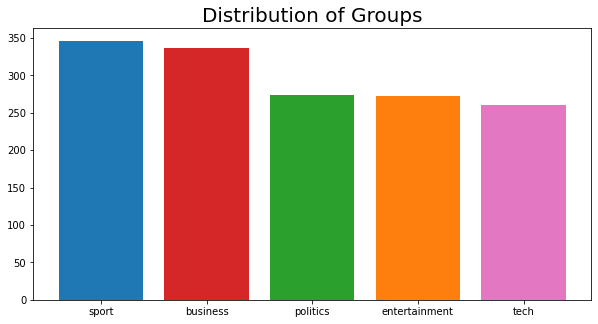

In [25]:
# Distribution of Groups
category_counts = train.Category.value_counts()
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:pink']
# colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']
# colors = ['lightsteelblue', 'lightgrey', 'darkseagreen', 'khaki', 'lavender']

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(category_counts.index, category_counts.values, color=colors)
ax.set_title('Distribution of Groups', fontsize=20);

In [4]:
# a helper function for data cleaning

def clean_text(text):

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)
    
    return text

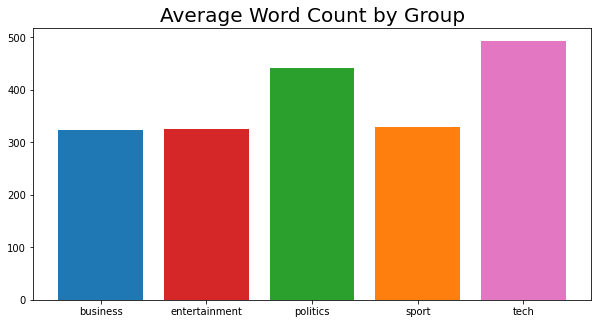

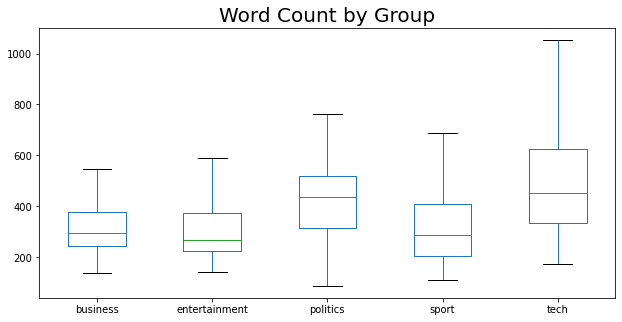

In [26]:
# Average Word Count by Group

# Clean the text first
df = train.copy()
df.Text = df.Text.apply(clean_text)

# Find the word counts for each document
df['word_count'] = [len(words) for words in df['Text'].str.split()]
group_word_counts = df.groupby('Category')['word_count'].mean()

# visualization 1:  mean word count by Group
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(group_word_counts.index, group_word_counts.values, color=colors)
ax.set_title('Average Word Count by Group', fontsize=20);

# visualization 2:  Boxplot of Word Count by Group
df.boxplot(by='Category', column='word_count', showfliers=False, grid=False, figsize=(10,5))
plt.title('Word Count by Group', fontsize=20)
plt.suptitle('')
plt.xlabel('');

The overall frequency of words was examined.  The following EDA shows that the vast majority of the words have very low frequency.  In turn, the total distibution of word frequency is not particularly informative.  However, data exploraton showed that almost 80% of the words occurred ten or fewer times, and only 5 words occurred more than 1,000 times.  The (selective) distibution of words occurring more than 100 and fewer than 1,000 times is shown, demonstrating an uneven distribution and more words occurring at lower frequency.

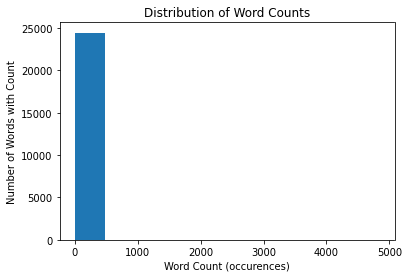

In [27]:
# Distribution of word counts (overall)

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(train.Text)
counts = X.toarray().sum(axis=0)

plt.hist(counts)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count (occurences)')
plt.ylabel('Number of Words with Count');

The distribution of the word counts is not particularly informative because there are so many low frequency words.  

In [7]:
# gross numerical distribution of word counts
print('total # words:', len(counts))
print('< 1000 count:', (counts < 1000).sum())  #24451
print('< 100 count:', (counts < 100).sum())   #23897
print('< 10 count:', (counts < 10).sum())   #19333

total # words: 24456
< 1000 count: 24451
< 100 count: 23897
< 10 count: 19333


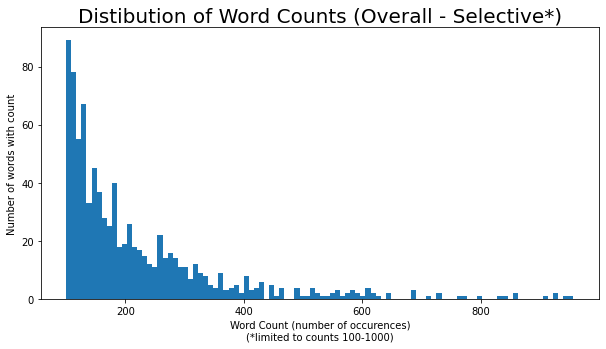

In [28]:
# Combine the train and test sets

full_set = pd.concat([train, test], axis=0, ignore_index=True)
df = full_set.copy()
df.Text = df.Text.apply(clean_text)

# Determine the word counts

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(df.Text)
counts = X.toarray().sum(axis=0)

# Distribution of Word Counts (selective)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(counts[(counts >= 100) & (counts <= 1000)], bins=100)
ax.set_title('Distibution of Word Counts (Overall - Selective*)', fontsize=20)
ax.set_xlabel('Word Count (number of occurences)\n(*limited to counts 100-1000)')
ax.set_ylabel('Number of words with count');

## Most Common Words (Overall)

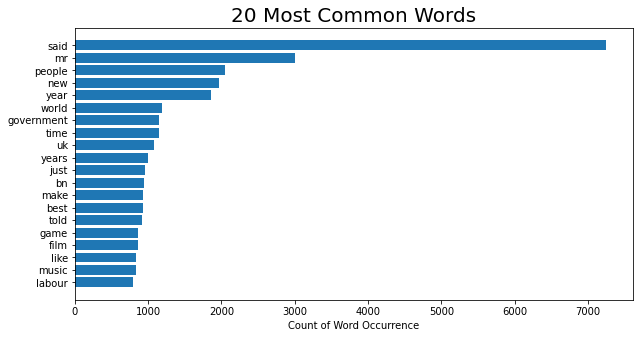

In [29]:
# Most Common Words

# Find the most common words

n = 20  # number of top words
vec = CountVectorizer(stop_words='english', max_features=n)
X = vec.fit_transform(df.Text)
words = vec.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Visualization

idx = np.argsort(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(y=words[idx], width=counts[idx])  # compare with plt.bar(x=words, height=counts)
ax.set_title('20 Most Common Words', fontsize=20)
ax.set_xlabel('Count of Word Occurrence');

# Modeling and Prediction with Non-Negative Matrix Factorization

## NMF Modeling

In [10]:
# Building datasets

# Note:  train and test data sets imported above
# Note:  helper function clean_text defined above

# Combine train and test sets

full_set = pd.concat([train, test], axis=0, ignore_index=True)

# Find dtm (document term matrix) matrix of tfidf values

vec = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=(1,2), max_df=0.9, min_df=2, stop_words='english')
X = vec.fit_transform(full_set.Text)

In [11]:
# Learn NMF model

nmf_model = NMF(n_components=5, init='nndsvda', max_iter=500, random_state=0)
nmf_model.fit(X)

# Show the top n words for each topic

n = 20
for index, topic in enumerate(nmf_model.components_):
    print(f'the top 20 words for topic # {index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-n:]])
    print()

the top 20 words for topic # 0
['robinson', 'chelsea', 'season', 'world', 'injury', 'club', 'france', 'coach', 'match', 'team', 'play', 'rugby', 'players', 'said', 'ireland', 'cup', 'wales', 'win', 'game', 'england']

the top 20 words for topic # 1
['leader', 'campaign', 'tories', 'tory', 'tax', 'chancellor', 'prime minister', 'prime', 'minister', 'howard', 'government', 'mr brown', 'mr blair', 'said', 'party', 'brown', 'election', 'blair', 'labour', 'mr']

the top 20 words for topic # 2
['analysts', 'rise', 'government', 'firm', 'dollar', 'shares', 'prices', 'company', 'china', 'market', 'economic', 'yukos', 'year', 'sales', 'bank', 'oil', 'economy', 'growth', 'said', 'bn']

the top 20 words for topic # 3
['ceremony', 'oscars', 'british', 'year', 'prize', 'star', 'nominations', 'comedy', 'aviator', 'director', 'festival', 'oscar', 'films', 'won', 'actress', 'actor', 'award', 'awards', 'best', 'film']

the top 20 words for topic # 4
['games', 'search', 'service', 'video', 'online', 'us

In [12]:
# Predict topics for documents

# Use NMF to find the predicted topics for documents
topic_results = nmf_model.transform(X)   # shape # (2225, 5)

# NMF learns a W matrix of m x k with correlation values for each document with each topic
# example:   topic_results[0]) = [0.         0.02647745 0.06104011 0.00101945 0.0056669 ]

# Assign the highest document-topic correlation to the document as prediction

topic_pred = topic_results.argmax(axis=1)
full_set['Topic'] = topic_pred

Now must decide how to label the topic numbers. Can be done with domain knowledge by looking at the top words in each topic.  
Alternatively, can be done with iterative combinations to find best accuracy.
In this case, we can take advantage of the domain expertise already applied to the train set and leverage that to assign labels to topic numbers.

In [13]:
# Assign Topic Label to the Topic Number

full_set.head(20)

# using a dict map to make the labels
topic_dict = {
    0: 'sport',
    1: 'politics',
    2: 'business',
    3: 'entertainment',
    4: 'tech'
}

full_set['Topic Label'] = full_set['Topic'].map(topic_dict)

## Assessing Model Performance

In [14]:
# Check Accuracy and Confusion Matrix

true = full_set[full_set.Category.notna()]['Category']
pred = full_set[full_set.Category.notna()]['Topic Label']

acc = accuracy_score(true, pred)
print('accuracy score:', acc)

conf_mat = confusion_matrix(true, pred)
# print(conf_mat)

# Optional:  Additional Scoring provided by classificaiton_report
# print(classification_report(true, pred))

accuracy score: 0.9221476510067114


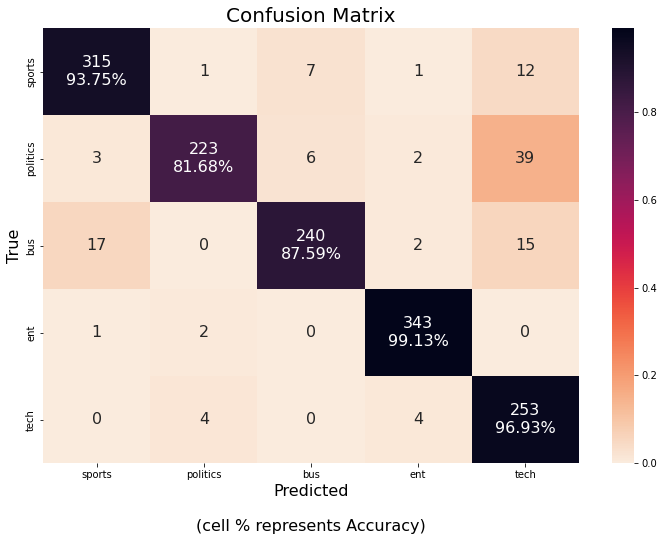

In [15]:
# Visualization of Confusion Matrix

labels = ['sports', 'politics', 'bus', 'ent', 'tech']
counts = conf_mat.flatten()
p = (conf_mat/np.sum(conf_mat, axis=1)).flatten()
accuracy = p[::6]

annots = [str(count) for count in counts]
for i in range(len(accuracy)):
    annots[i*6] = annots[i*6] + '\n' + f'{accuracy[i]:.2%}'

annots = np.asarray(annots).reshape(5,5)

fix, ax = plt.subplots(figsize=(12,8))
sns.heatmap(conf_mat/np.sum(conf_mat, axis=1), cmap='rocket_r', annot=annots, fmt='', annot_kws={'size': 16}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted\n\n(cell % represents Accuracy)', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [37]:
# Kaggle Scoring - Test Accuracy

predicted = full_set[full_set.Category.isnull()]['Topic Label']

submission = pd.DataFrame({
    'ArticleId': full_set[full_set.Category.isnull()]['ArticleId'],
    'Category': predicted
})
submission.to_csv('submission_nmf_unsupervised.csv', index=False)
print('submission output written to file')

submission output written to file


Kaggle score:  **0.93061**

In [16]:
nmf_test_acc = 0.93061

## NMF Parameter Tuning

In [18]:
# a helper function for model testing which accepts variable parameters
'''
any of (ngram_range, max_df, min_df, max_features, solver, beta_loss) can be specified; otherwise uses default value
returns list of paramater values used and accuracy score
'''

def model_testing (ngram_range = (1,1), max_df = 1.0, min_df = 1, max_features = None, solver = 'cd', beta_loss = 'frobenius'):

    vec = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
    X_opt = vec.fit_transform(full_set.Text)

    nmf_opt = NMF(n_components=5, init='nndsvda', solver=solver, beta_loss=beta_loss, max_iter=500, random_state=0)
    nmf_opt.fit(X_opt)

    pred_opt = nmf_opt.transform(X_opt).argmax(axis=1)  # .map(topic_dict)
    pred_opt = np.vectorize(topic_dict.get)(pred_opt)   # map np.array to dict values
    idx_tr = full_set[full_set.Category.notna()].index
    pred_opt = pred_opt[idx_tr]

    acc_opt = accuracy_score(true, pred_opt)
    # print('accuracy score:', acc_opt)

    return [str(ngram_range), max_df, min_df, max_features, solver, beta_loss, acc_opt]


In [19]:
cols = ['ngram_range', 'max_df', 'min_df', 'max_features', 'solver', 'beta_loss', 'accuracy']
results_tuning = pd.DataFrame(columns=cols)

param_list = [
    {},
    {'ngram_range': (1,2), 'max_df': 0.9, 'min_df': 2},
    {'ngram_range': (1,2), 'max_df': 0.9, 'min_df': 2, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 5, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 10, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 100},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 500},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 1000}
]

for params in param_list:
    res = np.array([model_testing(**params)])
    # print(res)
    df = pd.DataFrame(res, columns=cols)
    results_tuning = pd.concat([results_tuning, df], ignore_index=True)

results_tuning.accuracy = results_tuning.accuracy.astype(float).round(5)
results_tuning.style.highlight_max(subset='accuracy')

,ngram_range,max_df,min_df,max_features,solver,beta_loss,accuracy
0,"(1, 1)",1.000000,1,None,cd,frobenius,0.554360
1,"(1, 2)",0.900000,2,None,cd,frobenius,0.922150
2,"(1, 2)",0.900000,2,None,mu,kullback-leibler,0.954360
3,"(1, 2)",0.800000,5,None,mu,kullback-leibler,0.632210
4,"(1, 2)",0.800000,10,None,mu,kullback-leibler,0.597990
5,"(1, 2)",0.800000,20,None,mu,kullback-leibler,0.956380
6,"(1, 2)",0.8,20,100,mu,kullback-leibler,0.483890
7,"(1, 2)",0.8,20,500,mu,kullback-leibler,0.935570
8,"(1, 2)",0.8,20,1000,mu,kullback-leibler,0.956380


## Testing Optimized Model

In [20]:
# define optimized parameters

ngram_range=(1,2)
max_df=0.8
min_df=20
max_features=None
solver='mu'
beta_loss='kullback-leibler'

In [21]:
# model and predict with NMF and optimized parameters

vec = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
X_opt = vec.fit_transform(full_set.Text)

nmf_opt = NMF(n_components=5, init='nndsvda', solver=solver, beta_loss=beta_loss, max_iter=500, random_state=0)
nmf_opt.fit(X_opt)

pred_opt = nmf_opt.transform(X_opt).argmax(axis=1)  # .map(topic_dict)
pred_opt = np.vectorize(topic_dict.get)(pred_opt)   # map np.array to dict values
idx_tr = full_set[full_set.Category.notna()].index
pred_opt_tr = pred_opt[idx_tr]

In [22]:
# Assess training accuracy

acc_opt = accuracy_score(true, pred_opt_tr)
print('accuracy score:', acc_opt)

accuracy score: 0.9563758389261745


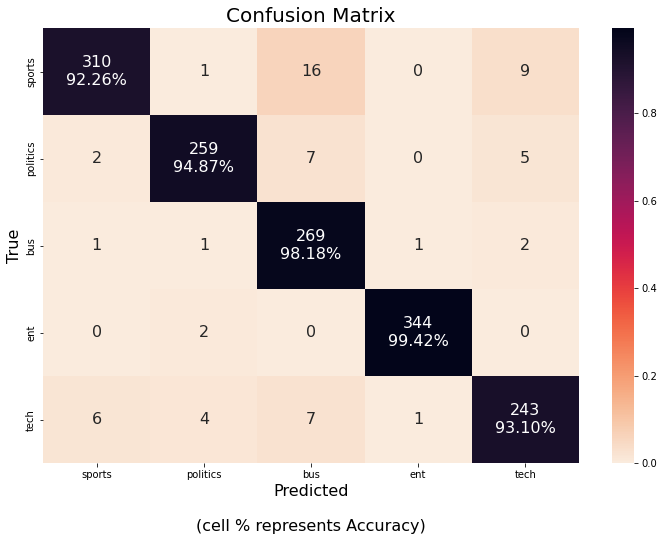

In [24]:
# Visualizaton of Confusion Matrix

conf_mat_opt = confusion_matrix(true, pred_opt_tr)
labels = ['sports', 'politics', 'bus', 'ent', 'tech']

counts = conf_mat_opt.flatten()
p = (conf_mat_opt/np.sum(conf_mat_opt, axis=1)).flatten()
accuracy = p[::6]

annots = [str(count) for count in counts]
for i in range(len(accuracy)):
    annots[i*6] = annots[i*6] + '\n' + f'{accuracy[i]:.2%}'

annots = np.asarray(annots).reshape(5,5)

fix, ax = plt.subplots(figsize=(12,8))
sns.heatmap(conf_mat_opt/np.sum(conf_mat_opt, axis=1), cmap='rocket_r', annot=annots, fmt='', annot_kws={'size': 16}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted\n\n(cell % represents Accuracy)', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=20);

In [43]:
# Kaggle Scoring - Test Accuracy

idx_test = full_set[full_set.Category.isnull()].index
pred_opt_test = pred_opt[idx_test]
predicted = pred_opt_test

submission = pd.DataFrame({
    'ArticleId': full_set[full_set.Category.isnull()]['ArticleId'],
    'Category': predicted
})
submission.to_csv('submission_nmf_unsupervised_tuned.csv', index=False)
print('submission output written to file')

submission output written to file


Kaggle score:  **0.94965**

In [47]:
nmf_tuned_test_acc = 0.94965

# Modeling and Prediction with Supervised Learning

Note that the train and test sets will both have some words that are not in the other set.  With tokenizing words, each set will have some differing features.  Supervised Learning models will require the same features to be present in both train and test sets in order to perform fit and predict functions and determine train and test accuracy scoring.  Alternatively, k-fold cross validation can be used training sets for a reasonable  measure of accuracy.  

Comparison with multiple Supervised Learning techniques.

In [45]:
# import modules

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Define datasets
#  Note:  previously defined tfidvectorized matrix based on full_text:  X = vec.fit_transform(full_set.Text)
# Training data set must contain all features but only observations with known classifications are used for training.

# separate the training set from the full_set
idx_train = full_set[full_set.Category.notna()].index
X_train = X[idx_train, :]
y = full_set.iloc[idx_train, :].Category  # could alternatively use `true` previously defined

# Note that KNN will addtionally requires that the data is normalized

In [49]:
# Train and test supervised models

classifiers = [MultinomialNB(), LogisticRegression(), SVC(), RandomForestClassifier()]
knn = KNeighborsClassifier(n_neighbors=5)

results_supervised = pd.DataFrame(columns = ['Model', 'CV-train'])

for clf in classifiers:
    cv = cross_val_score(clf, X_train, y, scoring='accuracy', cv=None, n_jobs=-1)      # default cv 'None' is 5-fold
    results_supervised.loc[len(results_supervised)] = {'Model': clf.__class__.__name__.replace('Classifier', ''), 'CV-train': cv.mean().round(5)}

# an additional round using KNN with normalized X matrix

import sklearn.preprocessing as preprocessing
X_train_normd = preprocessing.normalize(X_train, norm='l2')

clf=knn
cv = cross_val_score(clf, X_train_normd, y, scoring='accuracy', cv=None, n_jobs=-1)
results_supervised.loc[len(results_supervised)] = {'Model': clf.__class__.__name__.replace('Classifier', ''), 'CV-train': cv.mean().round(5)}

# results_supervised  # to view results

In [78]:
# add NMF results to results

results_supervised.rename(columns={'CV-train': 'Accuracy'}, inplace=True)

results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-train', 'Accuracy': acc.round(5)}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-test', 'Accuracy': nmf_test_acc}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-tuned-train', 'Accuracy': acc_opt.round(5)}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-tuned-test', 'Accuracy': nmf_tuned_test_acc}

results_supervised.style.highlight_max(subset='Accuracy')

,Model,Accuracy
0,MultinomialNB,0.962420
1,LogisticRegression,0.967790
2,SVC,0.966440
3,RandomForest,0.952350
4,KNeighbors,0.942950
5,NMF-train,0.922150
6,NMF-test,0.930610
7,NMF-tuned-train,0.956380
8,NMF-tuned-test,0.949650
